# HOMEWORK 4: PCA, Autoencoders, K-Means Clustering and fcNN

### Importing Libraries 

In [1]:
import tensorflow as tf
from autograd import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from autograd import grad, value_and_grad
from matplotlib import cm

from tensorflow.keras.datasets import mnist
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical 
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

## Exercise 1 – Final Project

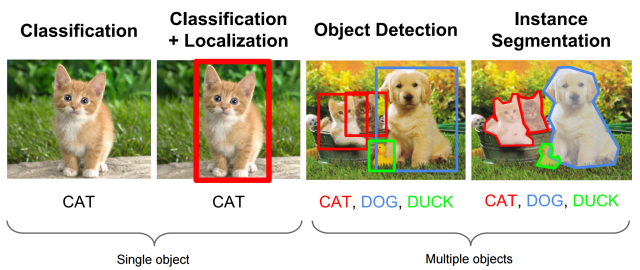

#### Image Recognition & Classification Using Animal Pictures
For my final project, I am interested in feeding animal pictures into a neural network algorithm consisting of different layers, hyperparameters, and cost functions in order to recognize and identify different classes. I obtained my dataset from Kaggle at: https://www.kaggle.com/datasets/alessiocorrado99/animals10. It contains 28000 medium quality google images of animals that can be categorized into: dog, cat, horse, spider, butterfly, chicken, sheep, cow, squirrel, and elephant. Some of the classification tasks I want to perform would include: (1) Binary Classification – classifying the image as one of two states (i.e. dog or not dog), (2) Multi-class Classification – classifying the image into either of the 10 classes, and (3) Imbalanced Classification – classification where the number of data in each class in unbalanced. By creating a neural network using TensorFlow & Keras, the algorithm would be designed to extract features and classify based on these inputs.

## Exercise 2 – MNIST Hand-Written Digits Classified using Python

In [2]:
train_labels.shape=(1,60000)
test_labels.shape=(1,10000)
train_images=(train_images.reshape(60000,784)).T
test_images=(test_images.reshape(10000,784)).T

In [3]:
# compute C linear combinations of input point, one per classifier
def model(x,w):
    ''' 

    Use this to compute C linear combinations of input points; one per classifier

    Parameters
    -------------

    x : vector 
    raw input

    w : vector
    contains bias & feature-touching weights 


    Return
    -------------

    a.T : vector
    column vector containing computed predictive value

    '''
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

# multiclass perceptron
def multiclass_perceptron(w,x,y,iter):
    ''' 

    The multi-class perceptron algorithm determines the ideal linear decision boundaries that separate the datapoints into multiple classes. 
    Instead of training two classifiers first and then fusing them into a single decision boundary, multi-class perceptron trains all classifiers simultaneously to satisfy the fusion rule.

    Parameters
    -------------

    w : vector 
    contains bias & feature-touching weights 

    x : array
    raw input
    
    y : array 
    data labels
    
    iter : array 
    used to iterate through batches 

    Return
    -------------

    multi-class perceptron cost : array
    computed multi-class perceptron cost function

    '''
    # get subset of points
    x_p = x[:,iter]
    y_p = y[:,iter]

    # pre-compute predictions on all points
    all_evals = model(x_p,w)

    # compute maximum across data points
    a =  np.max(all_evals,axis = 0)        

    # compute cost in compact form using numpy broadcasting
    b = all_evals[y_p.astype(int).flatten(),np.arange(np.size(y_p))]
    cost = np.sum(a - b)

    # return average
    return cost/float(np.size(y_p))

### 2.1 – Mini-Batch Optimization 

In [4]:
from autograd.misc.flatten import flatten_func
from autograd import grad as gradient 

# minibatch gradient descent
def batch_gradient_descent(g,w,x_train,y_train,alpha_choice,max_its,batch_size):
    ''' 

    The mini-batch gradient descent algorithm is a variation of the standard gradient descent that results in better optimization despite taking more computational steps.
    Instead of taking into consideration all data points for a single step, mini-baatch gradient descent takes clusters of data called batches and uses those to create a descent step.
    Mini-batch gradient descent should result in a more minimized cost function at each batch step and after each epoch (full cycle of batches). 
    

    Parameters
    -------------

    g : callable 
    input function
    
    w : array 
    initialization
    
    x_train : array 
    raw data
    
    y_train : array 
    data labels

    alpha_choice : int or str
    steplength parameter/learning rate

    max_its : int
    maximum number of iterations

    batch_size : int 
    number of data points in a batch

    Return
    -------------

    weight_history : list
    contains all the weights in the algorithm including the initial

    cost_history : list
    contains the evaluated cost function at the kth step including the starting value

    '''
    g_flat, unflatten, w = flatten_func(g,w) # flatten g and w to increase computation speed
    calc_grad = gradient(g_flat) # calculate the gradient of the flattened g 

    weight_history = [unflatten(w)]     # container for weight history
    cost_history = [g_flat(w,x_train,y_train,np.arange(y_train.shape[1]))]    # container for corresponding cost function history
    
    num_batches = y_train.shape[1]//batch_size # determine how many batches are needed for a full epoch – if batch size not a divisor then ignore
    
    for k in range(1,max_its+1): # run the gradient descent loop
        
        # check if alpha is diminishing or fixed
        if alpha_choice == "diminishing":
            alpha = 1/float(k)
        else: 
            alpha = alpha_choice
        
        for j in range(num_batches):
            mini_batch_size = np.arange(j*batch_size,min((j+1)*batch_size,y_train.shape[1])) # iterate through each batch within an epoch
            grad_eval = -calc_grad(w,x_train,y_train,mini_batch_size) # calculate the descent step corresponding to assigned batch size
            
            # take gradient descent step
            w = w + alpha*grad_eval
        
        # record weight and cost after each epoch
        weight_history.append(unflatten(w))
        cost_history.append(g_flat(w,x_train,y_train,np.arange(y_train.shape[1])))
        
    return weight_history,cost_history

### 2.2 – Implementing Mini-Batch Gradient Descent 

In [5]:
'Train Plot'

# Set the parameters for Run 1 – Mini-batch
g = multiclass_perceptron
N = train_images.shape[0] # specify the dimension
C = len(np.unique(train_labels)) # find the number of classes by looking at how many unique labels there are for the data
alpha_choice = 0.001; w = 0.1*np.random.randn(N+1,C); max_its = 5; batch_size = 200; 

# Run our algorithm 
weight_history_run1,cost_history_run1 = batch_gradient_descent(g,w,train_images,train_labels,alpha_choice,max_its,batch_size)

# Set the parameters for Run 2 – Full batch
batch_size = train_labels.shape[1] # specify a full batch

# Run our algorithm
weight_history_run2,cost_history_run2 = batch_gradient_descent(g,w,train_images,train_labels,alpha_choice,max_its,batch_size)

'Test Plot'

# Set the parameters for Run 1 – Mini-batch
g = multiclass_perceptron
N = test_images.shape[0]
C = len(np.unique(test_labels)) # find the number of classes by looking at how many unique labels there are for the data
alpha_choice = 0.001; w = 0.1*np.random.randn(N+1,C); max_its = 5; batch_size = 200; 

# Run our algorithm 
weight_history_run3,cost_history_run3 = batch_gradient_descent(g,w,test_images,test_labels,alpha_choice,max_its,batch_size)

# Set the parameters for Run 2 – Full batch
batch_size = test_labels.shape[1]

# Run our algorithm
weight_history_run4,cost_history_run4 = batch_gradient_descent(g,w,test_images,test_labels,alpha_choice,max_its,batch_size)


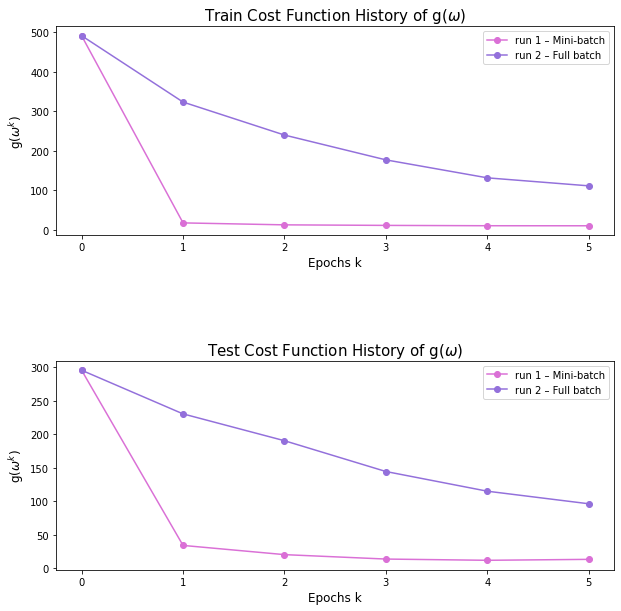

In [6]:
# Cost history plots

# create an array that is a range from 0 to the number of epochs
step_numbers = np.arange(0, max_its+1) 

# set the size and titles of the plot and the axis
fig, (ax5,ax6) = plt.subplots(2,figsize=(10, 10))
plt.subplots_adjust(hspace = 0.6)

ax5.set_title("Train Cost Function History of g($\omega$)", fontsize = 15) 
ax5.set_xlabel('Epochs k', fontsize = 12) # set x-axis title to the kth step in the algorithm
ax5.set_ylabel('g($\omega^k$)', fontsize = 12) # set y-axis title to the value of the cost function at the kth step

# plot the cost history of all runs for train
ax5.plot(step_numbers, cost_history_run1, color = 'orchid', marker = 'o', label = 'run 1 – Mini-batch')
ax5.plot(step_numbers, cost_history_run2, color = 'mediumpurple', marker = 'o', label = 'run 2 – Full batch')
ax5.legend()

# Plot test plot
ax6.set_title("Test Cost Function History of g($\omega$)", fontsize = 15) 
ax6.set_xlabel('Epochs k', fontsize = 12) # set x-axis title to the kth step in the algorithm
ax6.set_ylabel('g($\omega^k$)', fontsize = 12) # set y-axis title to the value of the cost function at the kth step
ax6.plot(step_numbers, cost_history_run3, color = 'orchid', marker = 'o', label = 'run 1 – Mini-batch')
ax6.plot(step_numbers, cost_history_run4, color = 'mediumpurple', marker = 'o', label = 'run 2 – Full batch')
ax6.legend()

plt.show()

#### Observations of cost function history plot
The mini-batch & full batch GDs start at the same cost function for both train and test, but the test cost function start at a larger g($\omega$) value. Across both test and train, mini-batch resulted in a lower cost function at all epochs indicated by g($\omega_{mini-batch}$) < g($\omega_{full batch}$) from Epochs 1-5. This means that mini-batch with a baatch size of 200 performs best. It appears that mini-batch gradient descent has effectively reached a minimum and showcases plateau behaviour across both test and train. On the other hand, it looks as if full batch is still in the process of minimizing and did not reach a plateau level. In both test and train, mini-batch resulted in rapid minimization going from epoch 0 to epoch 1, whereas full batch had a more gradual minimization.

### 2.3 – Histogram of Misclassifications

In [7]:
# Determining the best train w 
best_index = np.argmin(cost_history_run1)
best_w = weight_history_run1[best_index]

# Determine sum of each train class
sum_val = []
for i in np.unique(train_labels):
    sum_val += [np.sum(train_labels == i)] # finds how many points in ith class

    
 # Determining the best test w 
best_index2 = np.argmin(cost_history_run3)
best_w2 = weight_history_run3[best_index2]

# Determine sum of each test class
sum_val2 = []
for j in np.unique(test_labels):
    sum_val2 += [np.sum(test_labels == j)] # finds how many points in ith class

In [8]:
def miscount_multi(w, x, y, mark):
    ''' 

    Miscount of multi-class perceptron was obtain from homework 3. 
    This algorithm counts how many misclassifications there are within a set of different classes 
    The misclassifications is based on whether the set of classifications using fusion rule matches the given y label values

    Parameters
    -------------

    w : vector 
    contains bias & feature-touching weights

    x : array 
    collection of inputs

    y : array
    collection of labels for x inputs
    
    mark: str
    Identifier of train or test data

    Return
    -------------

    counter: integer array
    number of misclassifications for a given set of x, w, and y

    '''
    y = y.flatten()
    misc_data = {} # storage for class and number of misclassifications 
    eval_mod = model(x,w)
    for j in np.unique(y): # iterate through the different number of classes 
        counter = 0
        
        for k in range(len(y)):
            y_hat = np.argmax(eval_mod[:,k:k+1]) # generate an array of indices indicating which class the specified point is in
            
            if j == y[k]:
                if y_hat != y[k]: # if predicted label does not match actual label
                    counter += 1 # counts number of misclassifications if array of indices does not match with classifications in label y
            
            if mark == 'train': # train data
                misc_data[j] = 100*(counter/sum_val[j]) # proportion of misclassified train data
            
            else: # test data
                misc_data[j] = 100*(counter/sum_val2[j]) # proportion of misclassified test data
    
    return misc_data

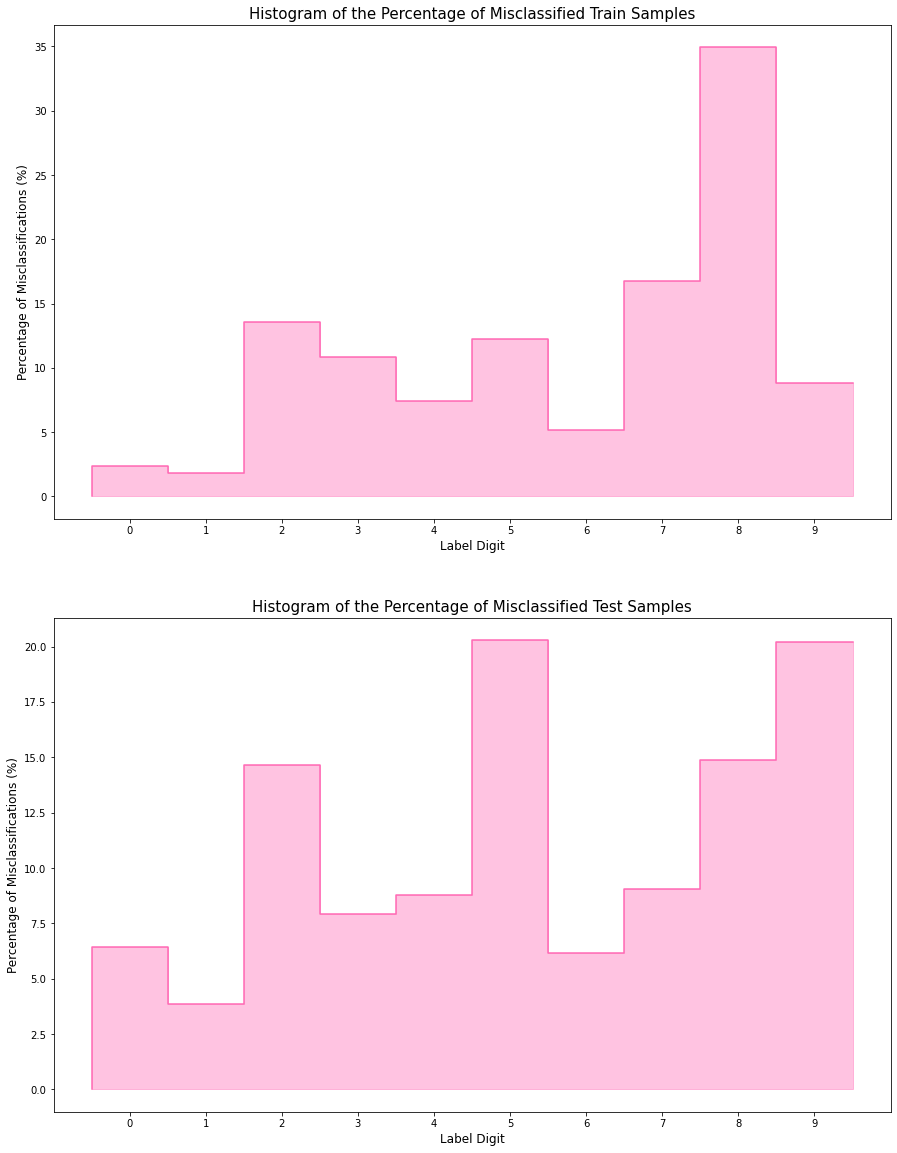

In [9]:
# Extract data for train histogram
ans = miscount_multi(best_w, train_images,train_labels,'train')
ans2 = []
fractions = ans.values()
for i in fractions:
    ans2 += [i]
ans2.insert(0,0) # insert 0 at the start to account for midpoint numbers
ans3 = np.array(ans2)

# Extract data for test histogram
ans4 = miscount_multi(best_w2, test_images,test_labels,'test')
ans5 = []
fractions2 = ans4.values()
for j in fractions2:
    ans5 += [j]
ans5.insert(0,0) # insert 0 at the start to account for midpoint numbers
ans6 = np.array(ans5)

# Create our bins
bins = [-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5] # have midpoint values equal to labels (0,1,2,...,9)

# Create our train histogram
fig, (axx,axy) = plt.subplots(2,figsize=(15, 20))
plt.subplots_adjust(hspace = 0.2)

axx.set_title("Histogram of the Percentage of Misclassified Train Samples", fontsize = 15) 
axx.set_xlabel('Label Digit', fontsize = 12) # set x-axis title to the kth step in the algorithm
axx.set_ylabel('Percentage of Misclassifications (%)', fontsize = 12) # set y-axis title to the value of the cost function at the kth step
positions = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9) # assign position of tick marks
labels = ("0", "1", "2", '3', '4', '5', '6', '7', '8', '9') # assign labels of ticks
axx.set_xticks(positions, labels)

# Plot the histogram of train misclassifications
axx.fill_between(bins,ans3, step="pre", alpha=0.4, color = 'hotpink')
axx.plot(bins,ans3, drawstyle="steps",color = 'hotpink')


# Create our test histogram
axy.set_title("Histogram of the Percentage of Misclassified Test Samples", fontsize = 15) 
axy.set_xlabel('Label Digit', fontsize = 12) # set x-axis title to the kth step in the algorithm
axy.set_ylabel('Percentage of Misclassifications (%)', fontsize = 12) # set y-axis title to the value of the cost function at the kth step
axy.set_xticks(positions, labels)

# Plot the histogram of test misclassifications
axy.fill_between(bins,ans6, step="pre", alpha=0.4, color = 'hotpink')
axy.plot(bins,ans6, drawstyle="steps",color = 'hotpink')

plt.show()

#### Observations from the histogram plot
The most misclassified digit in both test and train images is 8. There is quite a bit of variation in terms of the percentage of misclassifications across the rest of the digits. When comparing between test and train, they have similar levels of the percentage of misclassifications. For this run it seems that test has a lower peak percentage of misclassifications than train (occuring at digit 8). Running the algorithm changes the exact percentage of misclassifications, however, after every run digit 8 remains to be the most misclassified digit among the rest. 

## Exercise 3 – Autoencoder 

In [10]:
def model(x,C):
    ''' 

    Use this to encode our data

    Parameters
    -------------

    x : vector 
    raw input

    C : array
    Spanning matrix containing spanning vectors


    Return
    -------------

    a.T : vector
    encoded data

    '''
    return np.dot(C.T,x)
    
def autoencoder(C):
    ''' 

    Autoencoder is a form of unsupervised learning whereby our algorithm learns how to compress and encode data to then relearn how to reconstruct the data into decoded form.

    Parameters
    -------------

    C : array
    Spanning matrix containing spanning vectors


    Return
    -------------

    a.T : vector
    encoded data

    '''
    cost = np.sum((np.dot(C,model(x,C)) - x)**2)
    return cost/float(x.size)

### 3.1 – Implementing Gradient Descent on Autoencoder

In [11]:
def gradient_descent(g,alpha_choice,max_its,w):
    ''' 

    The standard gradient descent algorithm takes the first derivative or gradient of the function.
    Since the negative gradient is always descending, by evaluating this, the algorithm is able to locally find the minimum of a function.

    Parameters
    -------------

    g : callable 
    input function

    alpha_choice : int or str
    steplength parameter/learning rate

    max_its : int
    maximum number of iterations

    w : array 
    initialization


    Return
    -------------

    weight_history : list
    contains all the weights in the algorithm including the initial

    cost_history : list
    contains the evaluated cost function at the kth step including the starting value

    '''
    # compute gradient module using autograd
    gradient = value_and_grad(g)

    weight_history = [w]     # container for weight history
    cost_history = [g(w)]    # container for corresponding cost function history
    
    for k in range(1,max_its+1): # run the gradient descent loop
        
        # check if alpha is diminishing or fixed
        if alpha_choice == "diminishing":
            alpha = 1/float(k)
        else: 
            alpha = alpha_choice
            
        # compute the value of the function and the gradient at wk
        cost_eval,grad_eval = gradient(w) 

        # take gradient descent step
        w = w - alpha*grad_eval

        # record weight and cost
        weight_history.append(w)
        cost_history.append(g(w))
        
    return weight_history,cost_history

In [12]:
# Set the parameters
csvname = '2d_span_data_centered.csv'
x = np.loadtxt(csvname,delimiter=',')
g = autoencoder; alpha_choice = 10**(-4); max_its = 1000; w = 0.1*np.random.randn(2,1);
C = np.array([[-3.5],[3.5]])

# Run our algorithm 
weight_history_auto,cost_history_auto = gradient_descent(g,alpha_choice,max_its,w)

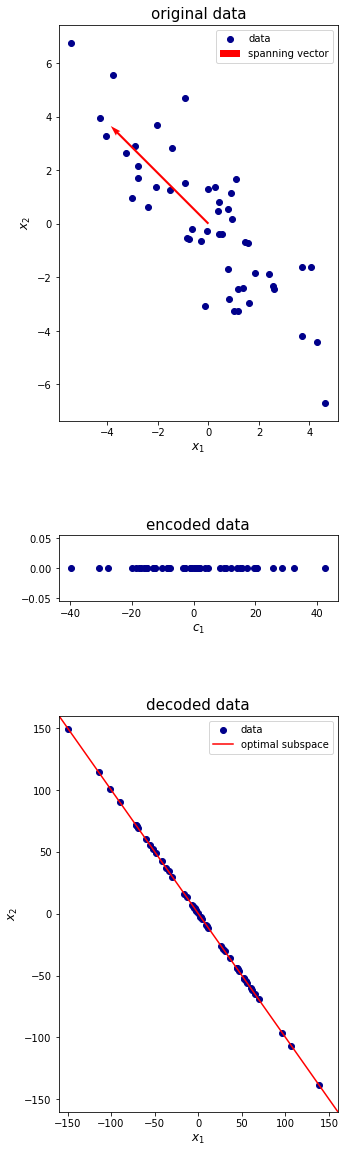

In [13]:
# Plotting our spanning set 

# Create separate plots
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(5, 20), gridspec_kw={'height_ratios': [6, 1, 6]})
plt.subplots_adjust(hspace = 0.4)

# original data 
ax1.set_title("original data", fontsize = 15) 
ax1.set_xlabel('$x_1$', fontsize = 12) 
ax1.set_ylabel('$x_2$', fontsize = 12)
ax1.scatter(x[0],x[1], label = 'data', color = 'darkblue')
origin = np.array([0, 0])
ax1.quiver(*origin, C[0], C[1], scale=10,color = 'red', label = 'spanning vector') # creates our spanning vector with base at origin
ax1.legend()

# encoding transformation
vals = model(x,C)[0] # obtain our encoded data (via wp = C.T*x)
ax2.set_title("encoded data", fontsize = 15) 
ax2.set_xlabel('$c_1$', fontsize = 12) 
ax2.scatter(vals,np.zeros_like(vals), color = 'darkblue')

# decoding transformation 
vals2 = np.dot(C,model(x,C)) # obtain our decoded data (via Cwp = C*C.T*x)
slope = (vals2[1][1] - vals2[1][0])/(vals2[0][1] - vals2[0][0]) # obtain the slope of our optimal subspace
ran = np.linspace(-200,200)
ax3.set_title("decoded data", fontsize = 15) 
ax3.set_xlabel('$x_1$', fontsize = 12) 
ax3.set_ylabel('$x_2$', fontsize = 12)
ax3.scatter(vals2[0],vals2[1], color = 'darkblue', label = 'data')
ax3.plot(ran,slope*ran,color = 'red', label = 'optimal subspace')
ax3.axis([-160,160,-160,160])
ax3.legend()

plt.show()

#### Observations of our data
The original data is plotted in the first graph along with the spanning vector contained in C. The data looks scattered around the general direction of the spanning vector. The encoded data is obtained by multiplying our original datapoints by C.T which resulted in a one dimensional plot. This happened because our original data was 2D (and encoding sometimes reduces the dimension of our data) and thus it resulted in 1D. The encoding space is spanned by c1 vector. The decoded data showcases xp points plotted in the optimal subspace spanned by CC.Tx (notice that all the points fall on the straight line). 

## Exercise 4 – PCA

In [14]:
def center(X):
    X_means = np.mean(X,axis=1)[:,np.newaxis]
    X_normalized = X - X_means

    return X_normalized

def compute_pcs(X,lam):
    # create the correlation matrix
    P = float(X.shape[1])
    Cov = 1/P*np.dot(X,X.T) + lam*np.eye(X.shape[0])

    # use numpy function to compute eigenvalues / vectors of correlation matrix
    D,V = np.linalg.eigh(Cov)
    return D,V

In [15]:
# Import the dataset
csvname = '2d_span_data.csv'
X_original = np.loadtxt(csvname,delimiter=',')

In [16]:
cent_x = center(X_original)
pcs = compute_pcs(cent_x,10**-7)

### Exercise 4.1 – Implementing Principle Component Analysis

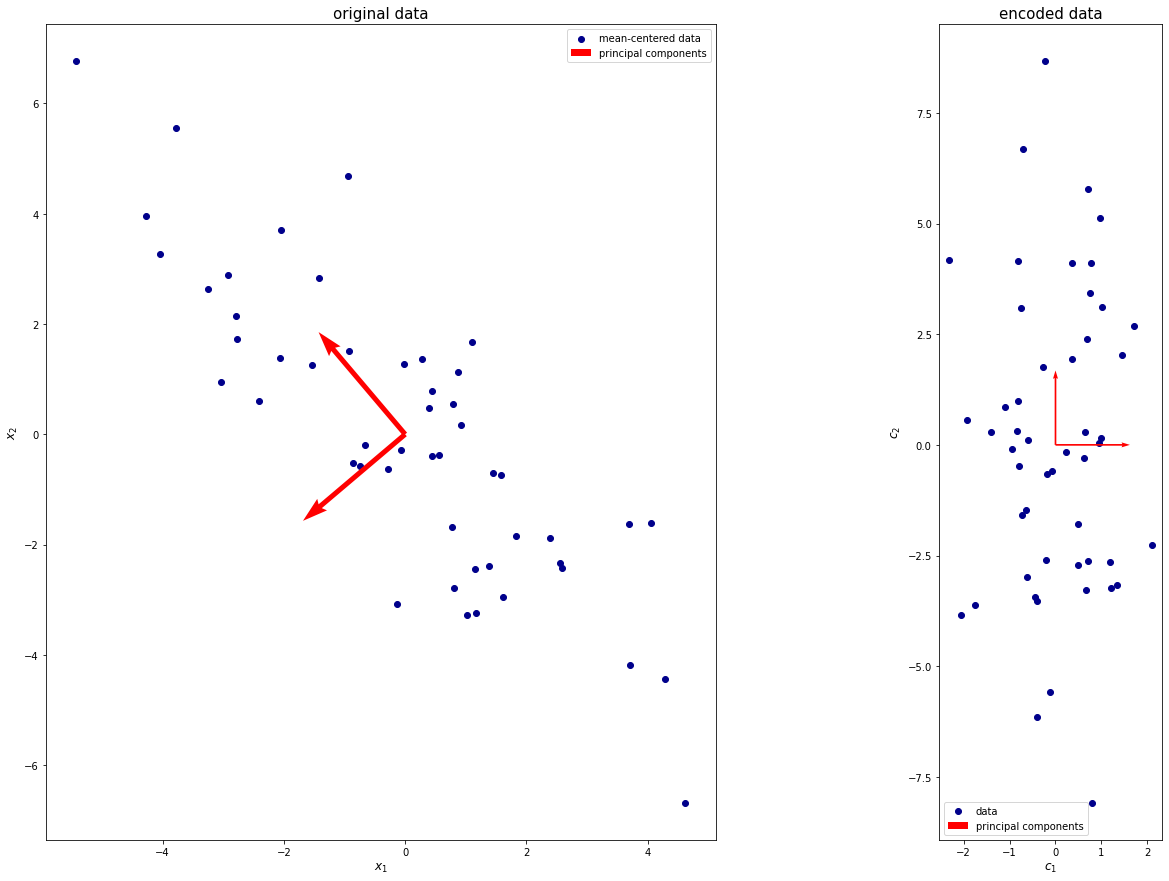

In [17]:
# Plotting our spanning set 

# Create separate plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 15), gridspec_kw={'width_ratios': [3, 1]})
plt.subplots_adjust(wspace = 0.5)

# original data 
cent_x = center(X_original) # obtain mean-centered data 
pcs = compute_pcs(cent_x,10**-7) # compute principal components using centered x
ax1.set_title("original data", fontsize = 15) 
ax1.set_xlabel('$x_1$', fontsize = 12) 
ax1.set_ylabel('$x_2$', fontsize = 12)
ax1.scatter(cent_x[0],cent_x[1], label = 'mean-centered data', color = 'darkblue')
origin = np.array([[0, 0], [0, 0]])
ax1.quiver(*origin, pcs[1][0], pcs[1][1], scale=5,color = 'red', label = 'principal components') # creates our orthonormal eigenvectors with base at origin
ax1.legend()

# encoding transformation
vals = model(cent_x,pcs[1]) # obtain our encoded data (via wp = V.T*x)
prin = compute_pcs(vals,10**-7) # compute principal components using non-centered x
ax2.set_title("encoded data", fontsize = 15) 
ax2.set_xlabel('$c_1$', fontsize = 12)
ax2.set_ylabel('$c_2$', fontsize = 12)
ax2.scatter(vals[0],vals[1], color = 'darkblue', label = 'data')
ax2.quiver(*origin, -prin[1][0], prin[1][1], scale=3,color = 'red', label = 'principal components')
ax2.legend()

plt.show()

#### Observations from data
The original data is mean-centered and plotted in the first graph along with the principal components computed with the mean-centered data. The data looks randomly scattered relative to the principal components. The encoded data is obtained by multiplying our mean-centered datapoints by the principal components. The resulting plot looks similar to the origina data except it was flipped along the y axis and rotated. The principal components are not located on the coordinate axes. 

## Exercise 5 – K-Means Clustering 

In [18]:
#Import data
data = np.loadtxt('blobs.dat')

### 5.1 – Creating our K-means Algorithm 

In [19]:
def update_assignments(data,centroids):
    ''' 

    Use this to assign our data points to clusters based on randomly picked centroids.
    Assignments are evaluated as which is the closest centroid from the data point. 

    Parameters
    -------------

    data : array 
    raw input

    centroids : array
    point acting as the center of a cluster


    Return
    -------------

    ass_clus : array
    contains the assignments for each point to an assigned cluster

    '''
    # initial guess at centroids given
    
    ass_clus = [] # storage for clustering assignments
    for j in range(len(data[0])):
        
        for i in data[:,j][np.newaxis,:]: # iterate through each x point and reshape to allow operation with centroids
            ass_clus += [np.argmin(np.sqrt(np.sum((i - centroids)**2,axis =1)))] # assign data class based on which centroid it is closest to
    
    return np.array(ass_clus)

def update_centroids(data,old_centroids,assignments):
    ''' 

    Use this to assign new centroids if data points are assigned new clusters.
    If there are no points within a cluster, keep the previous centroid. 

    Parameters
    -------------

    data : array 
    raw input

    old_centroids : array
    point acting as the center of a cluster
    
    assignments : array
    contains the assignments for each point to an assigned cluster


    Return
    -------------

    updated_cent : array
    new centroids based on the average of the cluster points

    '''
    
    updated_cent = [] # create a container for our new centeroids 
    
    for m in np.unique(assignments): # determine how many K clusters there are and its indices
        clus_ind = np.argwhere(assignments == m) # obtain the indices of the points for each cluster
        
        if np.size(clus_ind) != 0: # if there are data points in the cluster
            xp = data[:,clus_ind][:,:,0]
            updated_cent += [(np.sum(xp,axis=1))/xp.shape[1]] # calculate the average position of the points in each cluster for new centroid positions
        
        else: # if no points are in a cluster keep prevous centeroid 
            updated_cent += [old_centroids[m,:]]
            
    return np.array(updated_cent)

In [20]:
def update_loop(data,centroids,max_its):
    ''' 

    Use this loop through the process of choosing initial centroids, creating cluster assignments, and then updating centroid locations

    Parameters
    -------------

    data : array 
    raw input

    centroids : array
    point acting as the center of a cluster
    
    max_its : int
    maximum number of iterations


    Return
    -------------

    clus_ass, centroids : array
    returns two arrays for the cluster assignments and updated centroid locations, respectively 

    '''
    for l in range(max_its):
        # update cluster assignments 
        clus_ass = update_assignments(data,centroids)
        
        # update cluster locations 
        centroids = update_centroids(data,centroids,clus_ass)
        
    # update cluster assignments 
    clus_ass = update_assignments(data,centroids)
    return clus_ass, centroids

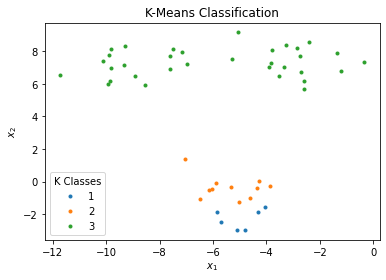

In [21]:
# Generate a plot of K-means with 3 centroids
k = 3
rand = np.random.choice(len(data[0]), k, replace=False) # pick 3 random data points
in_cent = data[:,rand]

assignments, centroids = update_loop(data,in_cent.T,5)

# Initialize plot objects
fig, (ax1) = plt.subplots(1, 1)
ax1.set_title('K-Means Classification')
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")

for index in range(3):
    ax1.plot(data[0,assignments == index],data[1,assignments == index],linestyle="",marker=".",label=index+1)

ax1.legend(title="K Classes")
plt.show()

#### Observations from K-means classification plot
When running the algorithm there are always three distinct classes that are depicted. For the most part, it is the same three clusters that show up but from time to time the separation of the classes differ. This is because we are randomly choosing 3 different points and there is a chance of choosing 2 points that are near each other causing the classification to differ. 

### 5.2 – Generating our Scree Plot

In [22]:
def avg_int_dist(data,centroids,assignments):
    ''' 

    Use this to compute the average intra-cluster distance between the data points in a cluster and its centroid.
    This is utilized for the Scree plot to determine the optimal number of assigned clusters.

    Parameters
    -------------

    data : array 
    raw input

    centroids : array
    point acting as the center of a cluster
    
    assignments : array
    contains the assignments for each point to an assigned cluster


    Return
    -------------

    average intra-cluster distance  : float
    computed average intra-cluster distance 

    '''
    total_int_dist = [] # container for intra-cluster distance
    
    for t in range(len(centroids[0])): # determine how many K clusters there are 
        
        for b in range(len(data[0])): # iterate through each data point
            if assignments[b] == t: # find data points within a specified cluster
                total_int_dist += [np.linalg.norm(data[:,b] - centroids[t,:])]  # calculate the distance of cluster points from each centroid 
    
    return((np.sum(total_int_dist))/len(data[0])) # take the average distance by summing and dividing by number of total datapoints

In [23]:
def scree_plot(data,max_K,max_its):
    ''' 

    Use this to display the Scree plot with varying number of clusters.
    Can observe how increasing the number of clusters affects the average intra-cluster distance, which can be used to determine the optimal number of clusters. 

    Parameters
    -------------

    data : array 
    raw input

    max_K : int
    maximum number of clusters
    
    max_its : int
    maximum number of iterations


    Return
    -------------

    Scree Plot : line plot
    demonstrates how number of clusters affects intra-cluster distances 

    '''
    K_avg_dist = [] # container for most minimal intra-cluster distance at K number of clusters
    
    for z in range(1,max_K+1): # iterate through number of clusters from 1-10
        avg_dist = [] # container for intra-cluster distance
        
        for k in range(max_its): # iterate through a maximum number of iterations
            rand = np.random.choice(len(data[0]),z, replace=False) # initialize centroids based on number of cluster (z)
            in_cent = data[:,rand]
            assignment_sweep, centroids_sweep = update_loop(data,in_cent.T,max_its) # obtain our assignments and centroids
            avg_dist += [avg_int_dist(data,centroids_sweep,assignment_sweep)] # compute intra-cluster distance
        
        best_ind = np.argmin(avg_dist) # find the minimum intra-cluster distance at given K
        K_avg_dist += [avg_dist[best_ind]] # append the smallest value of intra-cluster distance for a given K number of clusters
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_title("Scree Plot", fontsize = 15) 
    ax.set_xlabel('number of clusters', fontsize = 12)
    ax.set_xticks(np.linspace(1,max_K,max_K))
    ax.set_ylabel('Average Intra-cluster Distance', fontsize = 12)
    ax.plot(np.linspace(1,max_K,max_K),K_avg_dist, marker = "o", color = 'red')
    
    plt.show()
    

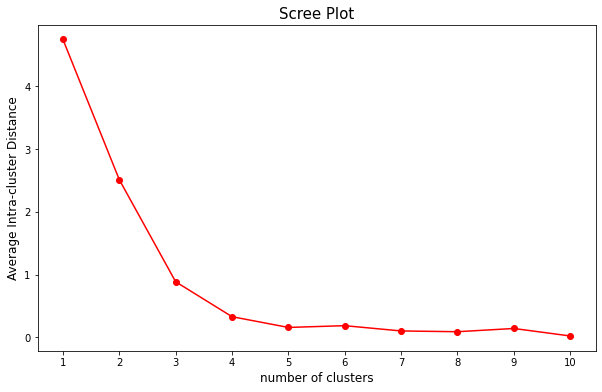

In [24]:
scree_plot(data,10,5)

#### Observations from the Scree plot
It looks like the average intra-cluster distance decreases rapidly from 1-3 and then after 3 the decrease is a lot more gradual and even fluctuates within 4-10. There is a clear indication for the correct value of K, which is 3 because adding more clusters does not significantly reduce the average intra-cluster distance and might even cause an increase in intra-cluster distance. 

## Exercise 6 – Fraud Detection 

In [25]:
import numpy as np
from urllib.request import urlopen

# import our dataset
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt'
raw_data = urlopen(url)
dataset = np.loadtxt(raw_data, delimiter=",")

In [26]:
# extract from dataset
X=dataset[:,[1,3]]
Y=dataset[:,4]

### 6.1 – Creating a 2D plot for Fraud Detection

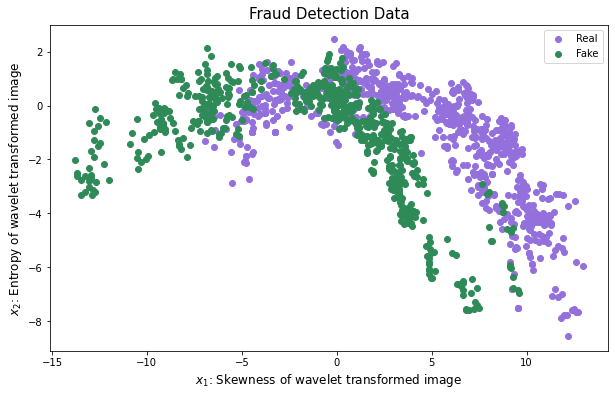

In [27]:
# find indices corresponding to real and fake 
real = np.argwhere(Y ==0)
fake = np.argwhere(Y ==1)

# set the size and titles of the plot and the axis
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Fraud Detection Data", fontsize = 15) 
ax.set_xlabel('$x_1$: Skewness of wavelet transformed image', fontsize = 12) # set x-axis title to the kth step in the algorithm
ax.set_ylabel('$x_2$: Entropy of wavelet transformed image', fontsize = 12) # set y-axis title to the value of the cost function at the kth step

# Real plot
plt.scatter((X[real,0]), (X[real,1]), color = 'mediumpurple', marker = 'o', label = 'Real')

# Fake plot
plt.scatter((X[fake,0]), (X[fake,1]), color = 'seagreen', marker = 'o', label = 'Fake')

plt.legend()
plt.show()

#### Can we visually separate the two datapoints by a straight line?
No, there is some overlap between the real and fake data points which makes it impossible to visually separate the two with a straight line without causing misclassifications. For the most part, it seems as if the real points are more right-shifted along the graph compared to the fake points which are more left-shifted. 

### 6.2 – Logistic Regression on Fraud Detection

In [28]:
# create our single neuron neural network (1 = sigmoid activation)
model = models.Sequential([
  layers.Dense(1, batch_input_shape=(None, 2),activation='sigmoid')])

# define our loss function, optimizer, and metrics 
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.15),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# access history 
history = model.fit(X, Y, epochs=400, batch_size=128)

2022-03-28 12:40:25.658660: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-28 12:40:25.659474: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-28 12:40:25.731871: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/400
11/11 [==============================] - 1s 2ms/step - loss: 0.9001 - accuracy: 0.5609
Epoch 2/400
11/11 [==============================] - 0s 2ms/step - loss: 0.5719 - accuracy: 0.6514
Epoch 3/400
11/11 [==============================] - 0s 3ms/step - loss: 0.5331 - accuracy: 0.7287
Epoch 4/400
11/11 [==============================] - 0s 2ms/step - loss: 0.5184 - accuracy: 0.7303
Epoch 5/400
11/11 [==============================] - 0s 2ms/step - loss: 0.5231 - accuracy: 0.7330
Epoch 6/400
11/11 [==============================] - 0s 3ms/step - loss: 0.5147 - accuracy: 0.7270
Epoch 7/400
11/11 [==============================] - 0s 3ms/step - loss: 0.5249 - accuracy: 0.7151
Epoch 8/400
11/11 [==============================] - 0s 2ms/step - loss: 0.5228 - accuracy: 0.7141
Epoch 9/400
11/11 [==============================] - 0s 3ms/step - loss: 0.5174 - accuracy: 0.7178
Epoch 10/400
11/11 [==============================] - 0s 3ms/step - loss: 0.5067 - accuracy: 0.7127
Epoch 11/

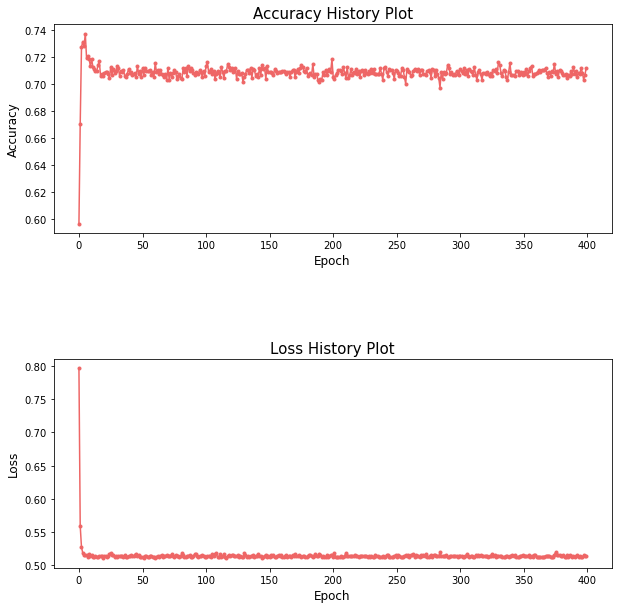

In [29]:
# initialize epoch steps 
epoch_num = np.arange(0,len(history.history['accuracy']))

# set the size and titles of the plot and the axis
fig, (ax1,ax2) = plt.subplots(2,figsize=(10, 10))
plt.subplots_adjust(hspace = 0.6)

# accuracy history
ax1.set_title("Accuracy History Plot", fontsize = 15) 
ax1.set_xlabel('Epoch', fontsize = 12) # set x-axis title to the kth step in the algorithm
ax1.set_ylabel('Accuracy', fontsize = 12) # set y-axis title to the value of the cost function at the kth step
ax1.plot(epoch_num,history.history['accuracy'], color='#EE6666', marker = '.', label = 'logistic regression')
plt.style.use("ggplot")

# loss history
ax2.set_title("Loss History Plot", fontsize = 15) 
ax2.set_xlabel('Epoch', fontsize = 12) # set x-axis title to the kth step in the algorithm
ax2.set_ylabel('Loss', fontsize = 12) # set y-axis title to the value of the cost function at the kth step
ax2.plot(epoch_num,history.history['loss'], color='#EE6666', marker = '.')
plt.style.use("ggplot")

plt.show()

#### Observations from history plots
There is a rapid change in accuracy and loss within the first 30 epochs but then the accuracy and loss plateaud and did not change significantly all up until the last epoch. The logistic regression is working sub-optimally as the accuracy only reached around 70% and the loss has only reached around 50%. Further, it seems that these end points result in a plateau demonstrating fluctuating behaviour, which indicates that increase the epoch value does not help optimize the algorithm (will still stay at around 70% accuracy and 50% loss). 

### 6.3 – Creating Contour Plot for Fraud Detection

/var/folders/61/2bknw8113b177snmp62m49p80000gn/T/ipykernel_29562/2194907637.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(z,ax=ax, label = 'Fake Probability')


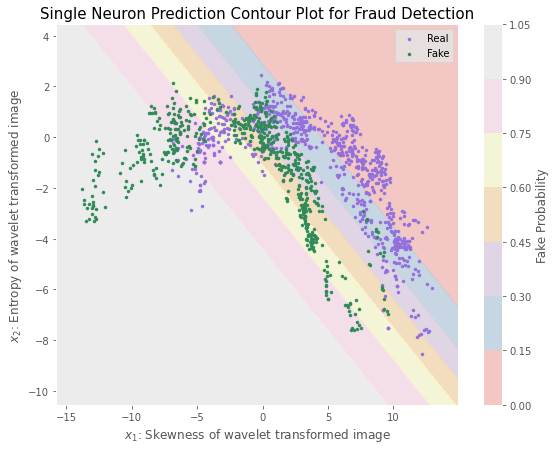

In [30]:
fig, ax = plt.subplots(figsize=(9, 7))
ax.grid(False)

# create our contour plot
x1list = np.linspace(np.min(X[:,0])-2, np.max(X[:,0])+2, 50) # define 50 points for x1
x2list = np.linspace(np.min(X[:,1])-2, np.max(X[:,1])+2, 50) # define 50 points for x2
x1,x2 = np.meshgrid(x1list,x2list)
x_val = np.stack((x1.flatten(), x2.flatten()), axis=1)
x_val2 = model.predict(x_val) # use our model prediction 
pred = x_val2.reshape(50,50)

z=ax.contourf(x1,x2,pred, cmap=cm.Pastel1, alpha = 0.6)
ax.set_title("Single Neuron Prediction Contour Plot for Fraud Detection", fontsize = 15) 
ax.set_xlabel('$x_1$: Skewness of wavelet transformed image', fontsize = 12) # set x-axis title to the kth step in the algorithm
ax.set_ylabel('$x_2$: Entropy of wavelet transformed image', fontsize = 12) # set y-axis title to the value of the cost function at the kth step
ax.scatter((X[real,0]), (X[real,1]), color = 'mediumpurple', marker = '.', label = 'Real')
ax.scatter((X[fake,0]), (X[fake,1]), color = 'seagreen', marker = '.', label = 'Fake')
plt.colorbar(z,ax=ax, label = 'Fake Probability')

plt.legend()
plt.show()

#### Observations from contour plot
Even though the data cannot be separated by a visual line, we have managed to indicate regions of probability of where the data is either fake or real using a single neuron neural network. As can be seen, the probability of the data being fake is highest in the lower left region of the plot which then decreases to around 0% in the top right region of the plot. This is somewhat consistent with the data as the real data points are more right shifted whereas the fake data points are more left shifted. An issue is that there are still some real data points that end up in the region where the probability of fake is close to 1 and there are some fake data points where the probability of fake is close to 0.

### 6.4 – Improvement of our Model

In [31]:
Y_c=to_categorical(Y,2)

# create our 8x2 neural network (8 = sigmoid activation & 2 = softmax activation)
model = models.Sequential([
  layers.Dense(8, batch_input_shape=(None, 2),activation='sigmoid'), 
  layers.Dense(2, activation='softmax')])

# define our loss function, optimizer, and metrics 
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.15),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# access history
history = model.fit(X,Y_c, epochs=400, batch_size=128)

Epoch 1/400
11/11 [==============================] - 0s 2ms/step - loss: 0.6738 - accuracy: 0.5535
Epoch 2/400
11/11 [==============================] - 0s 2ms/step - loss: 0.5843 - accuracy: 0.6348
Epoch 3/400
11/11 [==============================] - 0s 4ms/step - loss: 0.5702 - accuracy: 0.6250
Epoch 4/400
11/11 [==============================] - 0s 3ms/step - loss: 0.5575 - accuracy: 0.6415
Epoch 5/400
11/11 [==============================] - 0s 3ms/step - loss: 0.5427 - accuracy: 0.6756
Epoch 6/400
11/11 [==============================] - 0s 3ms/step - loss: 0.5341 - accuracy: 0.6805
Epoch 7/400
11/11 [==============================] - 0s 4ms/step - loss: 0.5259 - accuracy: 0.6982
Epoch 8/400
11/11 [==============================] - 0s 3ms/step - loss: 0.5296 - accuracy: 0.7027
Epoch 9/400
11/11 [==============================] - 0s 4ms/step - loss: 0.4989 - accuracy: 0.7146
Epoch 10/400
11/11 [==============================] - 0s 7ms/step - loss: 0.5019 - accuracy: 0.7232
Epoch 11/

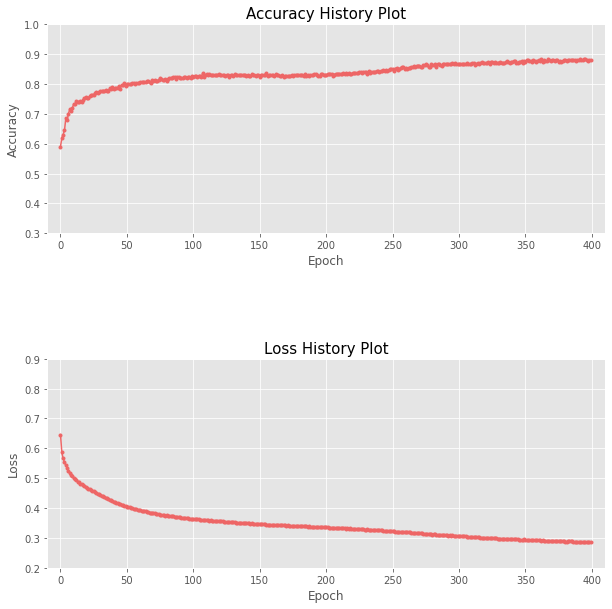

In [32]:
# initialize epoch steps 
epoch_num = np.arange(0,len(history.history['accuracy']))

# set the size and titles of the plot and the axis
fig, (ax1,ax2) = plt.subplots(2,figsize=(10, 10))
plt.subplots_adjust(hspace = 0.6)

# accuracy history
ax1.set_title("Accuracy History Plot", fontsize = 15) 
ax1.set_xlabel('Epoch', fontsize = 12) # set x-axis title to the kth step in the algorithm
ax1.set_ylabel('Accuracy', fontsize = 12) # set y-axis title to the value of the cost function at the kth step
ax1.plot(epoch_num,history.history['accuracy'], color='#EE6666', marker = '.', label = 'logistic regression')
ax1.axis([-10,410,0.3,1])
plt.style.use("ggplot")

# loss history
ax2.set_title("Loss History Plot", fontsize = 15) 
ax2.set_xlabel('Epoch', fontsize = 12) # set x-axis title to the kth step in the algorithm
ax2.set_ylabel('Loss', fontsize = 12) # set y-axis title to the value of the cost function at the kth step
ax2.plot(epoch_num,history.history['loss'], color='#EE6666', marker = '.')
ax2.axis([-10,410,0.2,0.9])
plt.style.use("ggplot")

plt.show()

#### Observations from history plots
There is a more rapid change in accuracy and loss within the first 100 epochs and then the accuracy and loss gradually changed up until the last epoch. The 8x2 neural network is working better than the single neural network as the accuracy reached a value close to 90% (while single neuron accuracy = 70%) and the loss has reached around 30% (while single neuron loss = 50%). These two parameters indicate that the 8x2 neural network better optimizes our classification of fake and real data points.

### 6.5 – Contour with Probability for Real

/var/folders/61/2bknw8113b177snmp62m49p80000gn/T/ipykernel_29562/2539828838.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(z,ax=ax3, label = 'Real Probability')


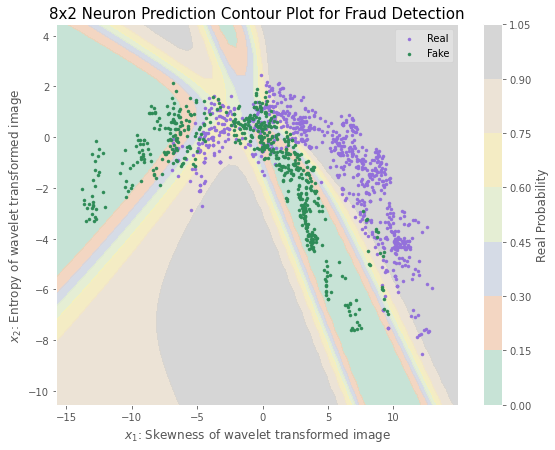

In [33]:
fig, ax3 = plt.subplots(figsize=(9, 7))
ax3.grid(False)

x1list = np.linspace(np.min(X[:,0])-2, np.max(X[:,0])+2, 50) # define 50 points for x1
x2list = np.linspace(np.min(X[:,1])-2, np.max(X[:,1])+2, 50) # define 50 points for x2
x1,x2 = np.meshgrid(x1list,x2list)
x_val = np.stack((x1.flatten(), x2.flatten()), axis=1)
x_val2 = model.predict(x_val) # use model prediction
pred = x_val2[:,0].reshape(50,50) # index for real probability 

z=ax3.contourf(x1,x2,pred, cmap=cm.Pastel2, alpha = 0.6)
ax3.set_title("8x2 Neuron Prediction Contour Plot for Fraud Detection", fontsize = 15) 
ax3.set_xlabel('$x_1$: Skewness of wavelet transformed image', fontsize = 12) # set x-axis title to the kth step in the algorithm
ax3.set_ylabel('$x_2$: Entropy of wavelet transformed image', fontsize = 12) # set y-axis title to the value of the cost function at the kth step
ax3.scatter((X[real,0]), (X[real,1]), color = 'mediumpurple', marker = '.', label = 'Real')
ax3.scatter((X[fake,0]), (X[fake,1]), color = 'seagreen', marker = '.', label = 'Fake')
plt.colorbar(z,ax=ax3, label = 'Real Probability')

plt.legend()
plt.show()

#### Observations of 8x2 Neuron Prediction
The 8x2 neural network resulted in a contour plot with regions that are not linear but more fluidic regions that more closely fit the data. The single neural network contour plot had bar-shaped regions which resulted in some fake points to have high probabilities of being real and some real points to have low probabilities of being real. The 8x2 neural network has the majority of the fake points in the region where the probability is close to 0 (near green, red, and blue). In addition, the majority of the real points are in the region where the probability is close to 1 (near black, brown, and yellow regions). The only ambiguous regions are where the data points overlap which resulted in values close to 50%. When considering the contour, accuracy, and loss plots we can be certain that the 8x2 neural network is better in optimization tha the single neural network. 